# Detector de QR Codes Maliciosos

#### Alunos: Henrique Nastari Corrêa e Lucas Lopes
#### Orientador: Prof. Dr. Antonino Feitosa Neto

Projeto de detecção de QR Codes maliciosos utilizando Python e OpenCV válido como atividade avaliativa para disciplina de Processamento Digital de Imagens do curso de Tecnologia em Análise e Desenvolvimento de Sistemas da Universidade Federal do Rio Grande do Norte (UFRN).

##### AVISO IMPORTANTE: Todas as imagens de QR Codes utilizadas no projeto têm o objetivo de gerar os QR codes visualmente e ter o texto decodificado para análise no algoritmo, todos os exemplos de URLs de phishing simulado URLs Encurtadas e URLs com muitos parêmetros suspeitos são perfeitamente seguros. Os exemplos de tel: e smsto: também são seguros para geração e análise, desde que você não execute a ação sugerida pelo seu celular ao escanear.

##### Links dos QR Codes utilizados foram gerados pelo Gemini.

##### Importando bibliotecas necessárias:

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pyzbar.pyzbar as pyzbar
import cv2

##### Exibir imagens de QR Codes que serão utilizados no projeto:

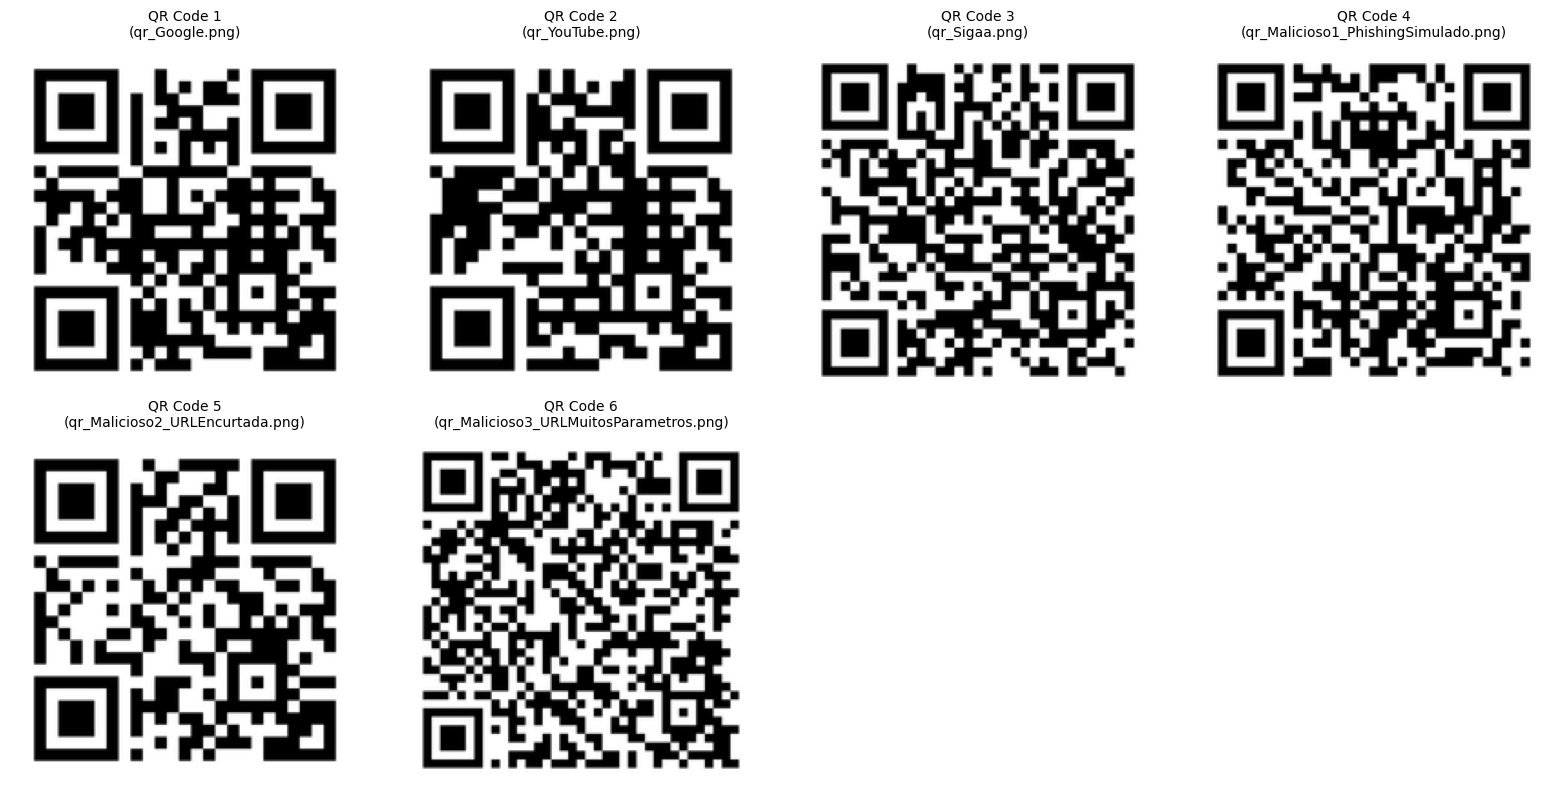

In [7]:
# Função para carregar a imagem
def carregar_imagem(caminho_imagem):
    try:
        img = cv2.imread(caminho_imagem)
        if img is None:
            print(f"Aviso: Não foi possível carregar a imagem em: {caminho_imagem}. Verifique o caminho ou o formato do arquivo.")
            return None
        return img
    except Exception as e:
        print(f"Erro inesperado ao carregar a imagem {caminho_imagem}: {e}")
        return None

# --- Lista de caminhos para as suas imagens de QR Code ---
caminhos_qr_codes = [
    "img/qr_Google.png",       # Exemplo de um QR code seguro do Google
    "img/qr_YouTube.png",        # Exemplo de um QR code seguro do YouTube
    "img/qr_Sigaa.png",    # Exemplo de um QR code seguro do SIGAA
    "img/qr_Malicioso1_PhishingSimulado.png", # Exemplo de phishing simulado
    "img/qr_Malicioso2_URLEncurtada.png", # Exemplo de URL encurtada
    "img/qr_Malicioso3_URLMuitosParametros.png"# Exemplo de URL com muitos parâmetros suspeitos
]

# --- Carregar e exibir as imagens de QR Code ---
num_colunas = 4
num_linhas = (len(caminhos_qr_codes) + num_colunas - 1) // num_colunas

plt.figure(figsize=(num_colunas * 4, num_linhas * 4))

for i, caminho in enumerate(caminhos_qr_codes):
    imagem_qr = carregar_imagem(caminho)

    plt.subplot(num_linhas, num_colunas, i + 1)

    if imagem_qr is not None:
        imagem_qr_rgb = cv2.cvtColor(imagem_qr, cv2.COLOR_BGR2RGB)
        plt.imshow(imagem_qr_rgb)
        plt.title(f"QR Code {i+1}\n({caminho.split('/')[-1]})", fontsize=10) # Título com nome do arquivo
        plt.axis('off')
    else:
        plt.text(0.5, 0.5, "ERRO\nIMAGEM NÃO CARREGADA",
                 horizontalalignment='center', verticalalignment='center',
                 transform=plt.gca().transAxes, color='red', fontsize=10)
        plt.title(f"Falha: {caminho.split('/')[-1]}", fontsize=10)
        plt.axis('off')

plt.tight_layout()
plt.show()

##### Geração de ruídos para simulação de imagens de QR Codes com problemas de visualização:

In [11]:
def carregar_imagem(caminho_imagem):
    try:
        img = cv2.imread(caminho_imagem)
        if img is None:
            print(f"Aviso: Não foi possível carregar a imagem em: {caminho_imagem}. Verifique o caminho ou o formato do arquivo.")
            return None
        return img
    except Exception as e:
        print(f"Erro inesperado ao carregar a imagem {caminho_imagem}: {e}")
        return None

def adicionar_ruido_gaussiano(imagem, media=0, variancia=500):
    """
    media: Média da distribuição Gaussiana.
    variancia: Variância da distribuição Gaussiana (quanto maior, mais ruído).
    """
    row, col, ch = imagem.shape
    sigma = variancia**0.5

    # Gera ruído Gaussiano com a mesma forma da imagem
    gauss = np.random.normal(media, sigma, (row, col, ch))
    gauss = gauss.reshape(row, col, ch)

    noisy_image = imagem.astype(np.float32) + gauss

    # Garante que os valores de pixel permaneçam no intervalo [0, 255] e converte de volta para uint8
    return np.clip(noisy_image, 0, 255).astype(np.uint8)

def adicionar_ruido_sal_pimenta(imagem, densidade=0.03):
    """
    densidade: Proporção de pixels que serão afetados (ex: 0.03 = 3%).
    """
    output = np.copy(imagem) # Cria uma cópia para não modificar a imagem original
    total_pixels = imagem.size // imagem.shape[2]

    # Adicionar "sal" (pixels brancos)
    num_salt = int(np.ceil(densidade * total_pixels * 0.5)) # Metade da densidade para sal
    # Seleciona coordenadas aleatórias
    coords_salt_x = np.random.randint(0, imagem.shape[0] - 1, num_salt)
    coords_salt_y = np.random.randint(0, imagem.shape[1] - 1, num_salt)
    output[coords_salt_x, coords_salt_y, :] = 255 # Define píxels como branco (255)

    # Adicionar "pimenta" (pixels pretos)
    num_pepper = int(np.ceil(densidade * total_pixels * 0.5)) # Metade da densidade para pimenta
    # Seleciona coordenadas aleatórias
    coords_pepper_x = np.random.randint(0, imagem.shape[0] - 1, num_pepper)
    coords_pepper_y = np.random.randint(0, imagem.shape[1] - 1, num_pepper)
    output[coords_pepper_x, coords_pepper_y, :] = 0 # Define píxels como preto (0)

    return output

def simular_sombreamento(imagem, intensidade_min=0.2, intensidade_max=1.0, direcao='esquerda_para_direita'):
    """
    intensidade_min: Fator mínimo de iluminação (0.0 a 1.0).
    intensidade_max: Fator máximo de iluminação (0.0 a 1.0).
    direcao: Direção do sombreamento ('esquerda_para_direita', 'topo_para_baixo').
    """
    h, w, _ = imagem.shape
    sombra_map = np.zeros((h, w), dtype=np.float32)

    if direcao == 'esquerda_para_direita':
        for col_idx in range(w):
            sombra_map[:, col_idx] = np.linspace(intensidade_max, intensidade_min, w)[col_idx]
    elif direcao == 'topo_para_baixo':
        for row_idx in range(h):
            sombra_map[row_idx, :] = np.linspace(intensidade_max, intensidade_min, h)[row_idx]
    else:
        print("Direção de sombreamento não suportada. Usando 'esquerda_para_direita' como padrão.")
        for col_idx in range(w):
            sombra_map[:, col_idx] = np.linspace(intensidade_max, intensidade_min, w)[col_idx]

    # Expande o mapa de sombra para 3 canais para multiplicar com a imagem colorida
    sombra_map_3ch = np.stack([sombra_map, sombra_map, sombra_map], axis=-1)

    # Aplica o sombreamento multiplicando a imagem pelo mapa
    shaded_image = imagem.astype(np.float32) * sombra_map_3ch

    # Garante que os valores de pixel permaneçam no intervalo [0, 255] e converte de volta para uint8
    return np.clip(shaded_image, 0, 255).astype(np.uint8)

##### Exibindo as imagens de QR Codes com ruídos adicionados:

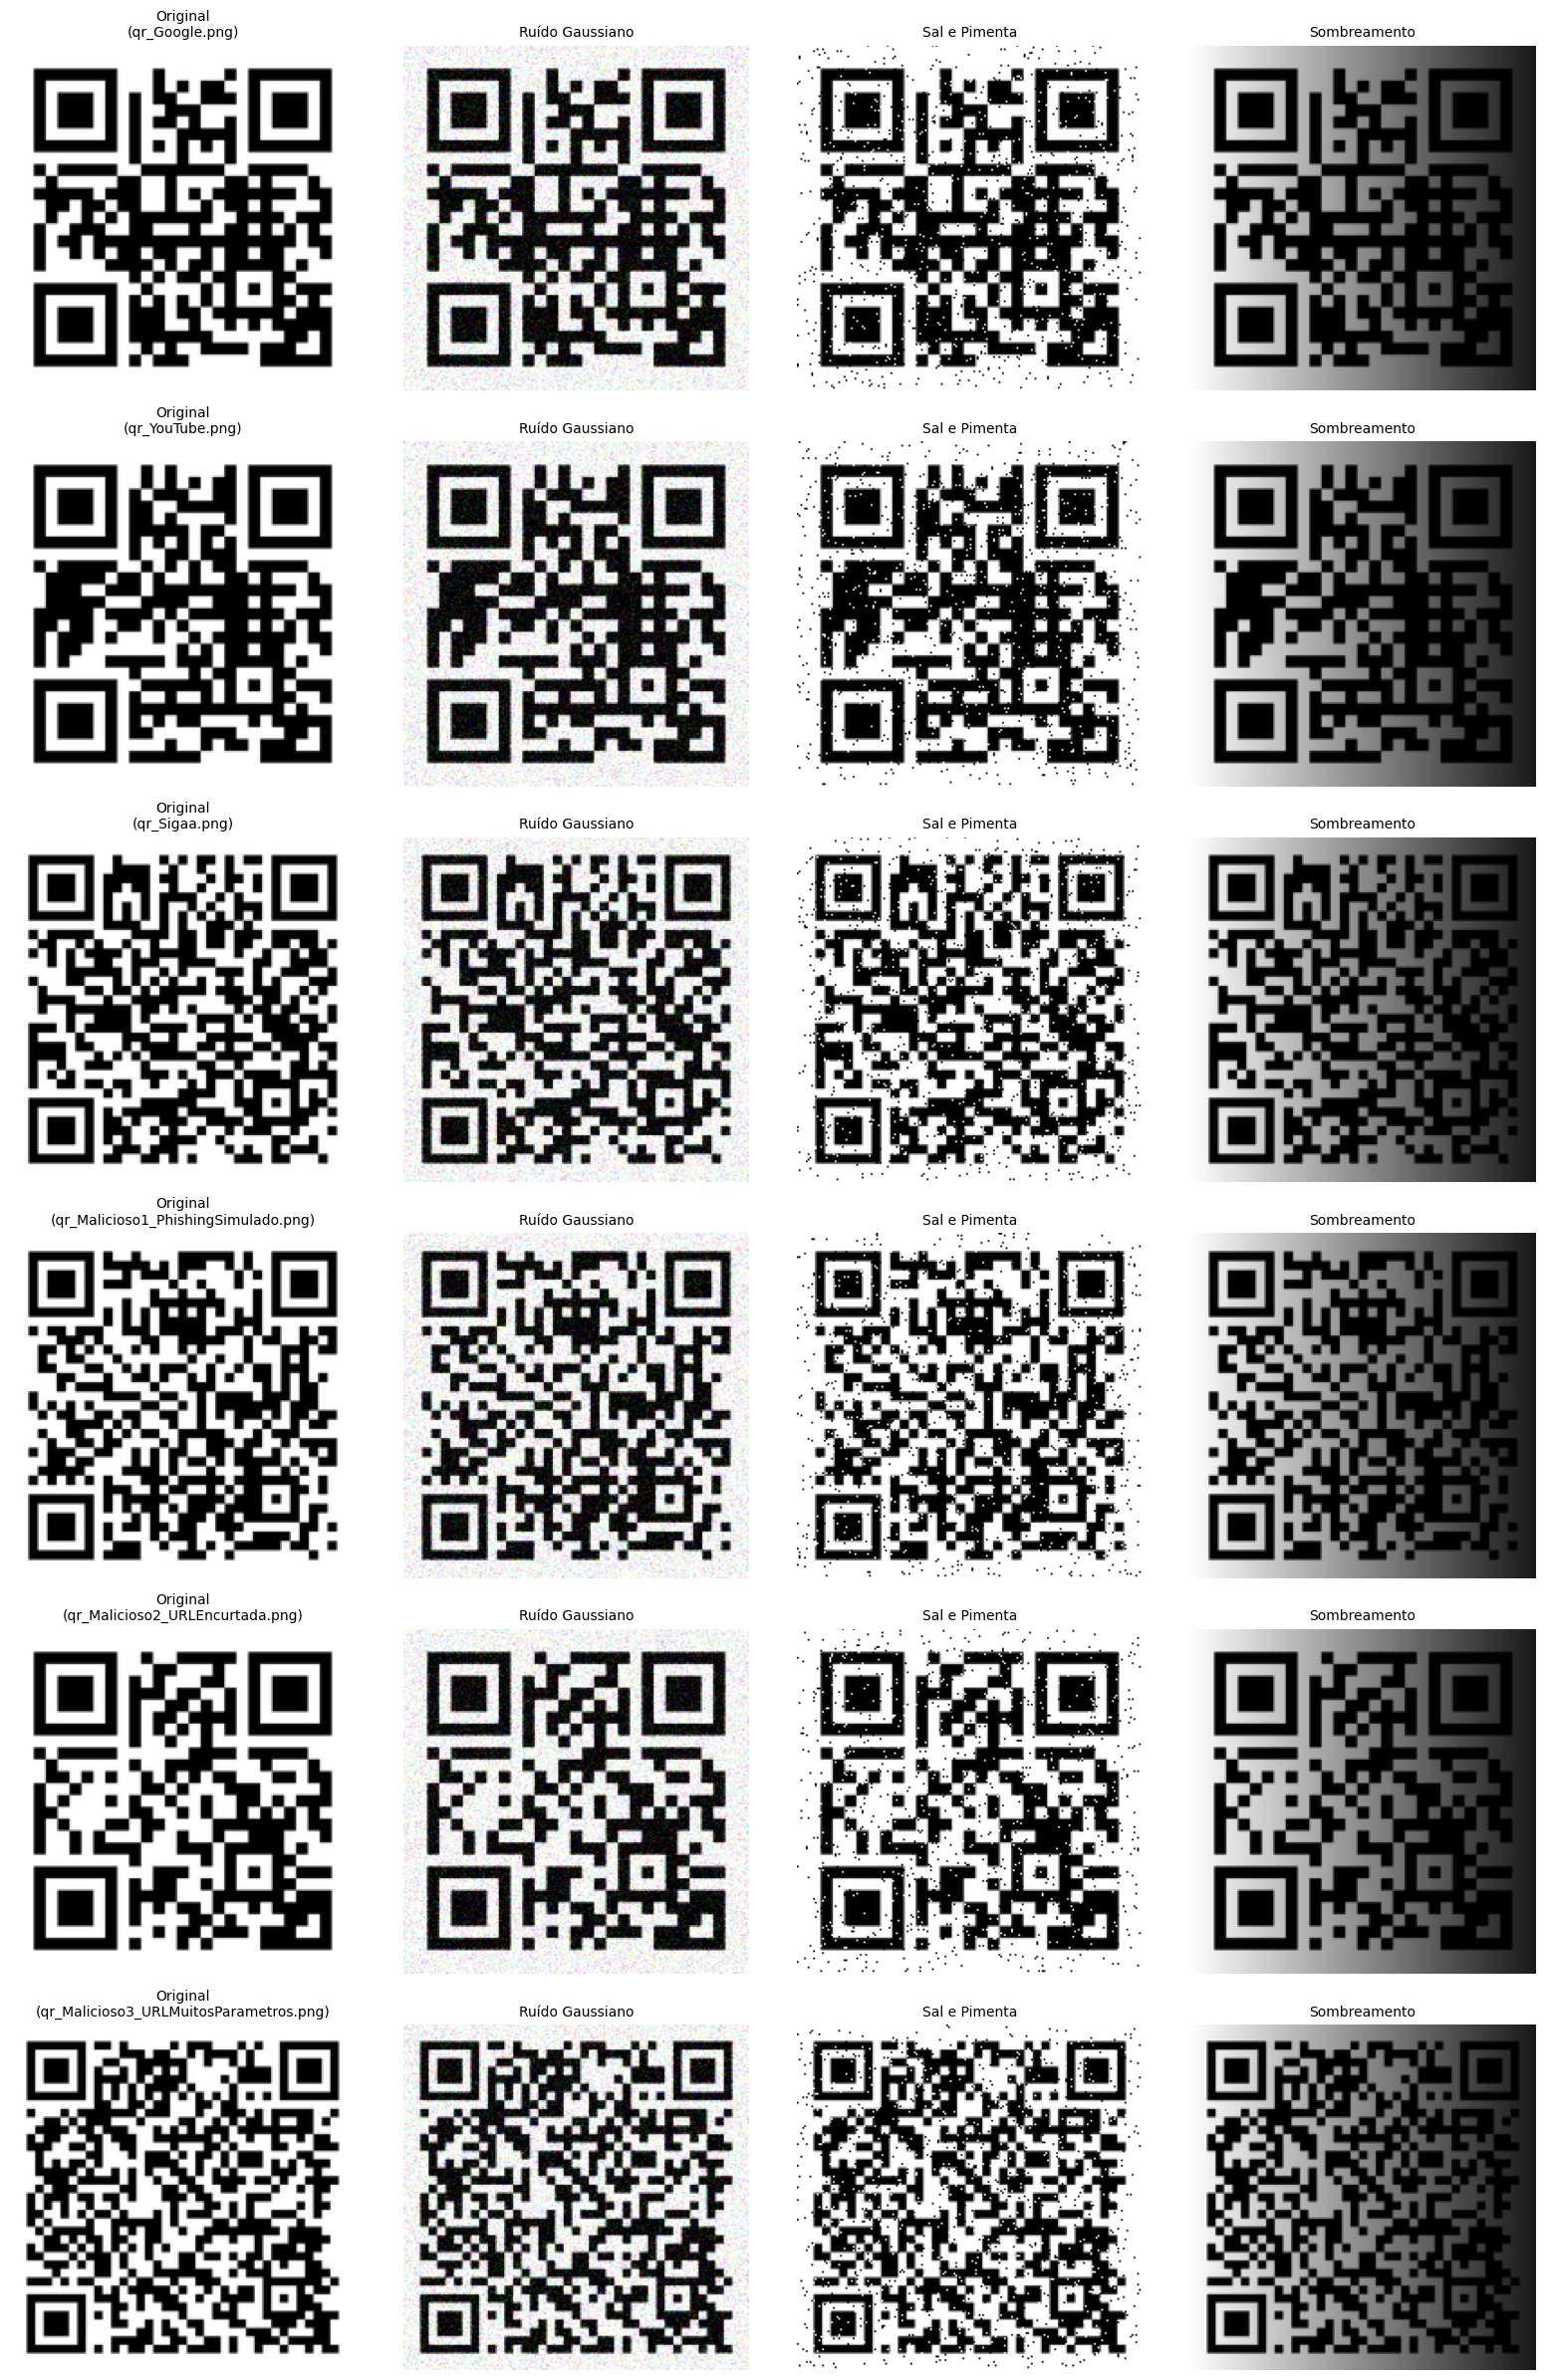

In [13]:
caminhos_qr_codes_originais = [
    "img/qr_Google.png",       # Exemplo de um QR code seguro do Google
    "img/qr_YouTube.png",        # Exemplo de um QR code seguro do YouTube
    "img/qr_Sigaa.png",    # Exemplo de um QR code seguro do SIGAA
    "img/qr_Malicioso1_PhishingSimulado.png", # Exemplo de phishing simulado
    "img/qr_Malicioso2_URLEncurtada.png", # Exemplo de URL encurtada
    "img/qr_Malicioso3_URLMuitosParametros.png"# Exemplo de URL com muitos parâmetros suspeitos
]

num_tipos_ruido = 3 # Gaussiano, Sal e Pimenta, Sombreamento
imagens_por_qr_code = num_tipos_ruido + 1 # Original + 3 tipos de ruído

# Número de colunas desejado na grade final para todas as imagens (ex: 4 imagens por linha)
num_colunas_grade = 4
num_linhas_grade = int(np.ceil(len(caminhos_qr_codes_originais) * imagens_por_qr_code / num_colunas_grade))

plt.figure(figsize=(num_colunas_grade * 4, num_linhas_grade * 4)) # Ajusta o tamanho da figura

posicao_atual = 1

for i, caminho_original in enumerate(caminhos_qr_codes_originais):
    imagem_original = carregar_imagem(caminho_original)

    if imagem_original is not None:
        imagem_original_rgb = cv2.cvtColor(imagem_original, cv2.COLOR_BGR2RGB)

        # 1. Plotar a imagem Original
        plt.subplot(num_linhas_grade, num_colunas_grade, posicao_atual)
        plt.imshow(imagem_original_rgb)
        plt.title(f"Original\n({caminho_original.split('/')[-1]})", fontsize=10)
        plt.axis('off')
        posicao_atual += 1

        # 2. Plotar a imagem com Ruído Gaussiano
        imagem_gaussiano = adicionar_ruido_gaussiano(imagem_original.copy(), variancia=800)
        imagem_gaussiano_rgb = cv2.cvtColor(imagem_gaussiano, cv2.COLOR_BGR2RGB)
        plt.subplot(num_linhas_grade, num_colunas_grade, posicao_atual)
        plt.imshow(imagem_gaussiano_rgb)
        plt.title("Ruído Gaussiano", fontsize=10)
        plt.axis('off')
        posicao_atual += 1

        # 3. Plotar a imagem com Ruído Sal e Pimenta
        imagem_sal_pimenta = adicionar_ruido_sal_pimenta(imagem_original.copy(), densidade=0.05)
        imagem_sal_pimenta_rgb = cv2.cvtColor(imagem_sal_pimenta, cv2.COLOR_BGR2RGB)
        plt.subplot(num_linhas_grade, num_colunas_grade, posicao_atual)
        plt.imshow(imagem_sal_pimenta_rgb)
        plt.title("Sal e Pimenta", fontsize=10)
        plt.axis('off')
        posicao_atual += 1

        # 4. Plotar a imagem com Sombreamento
        imagem_sombreado = simular_sombreamento(imagem_original.copy(), intensidade_min=0.1, direcao='esquerda_para_direita')
        imagem_sombreado_rgb = cv2.cvtColor(imagem_sombreado, cv2.COLOR_BGR2RGB)
        plt.subplot(num_linhas_grade, num_colunas_grade, posicao_atual)
        plt.imshow(imagem_sombreado_rgb)
        plt.title("Sombreamento", fontsize=10)
        plt.axis('off')
        posicao_atual += 1
    else:
        print(f"Ignorando processamento para {caminho_original} devido a erro de carregamento.")
        for _ in range(imagens_por_qr_code):
            plt.subplot(num_linhas_grade, num_colunas_grade, posicao_atual)
            plt.text(0.5, 0.5, "ERRO NO CARREGAMENTO",
                     horizontalalignment='center', verticalalignment='center',
                     transform=plt.gca().transAxes, color='red', fontsize=10)
            plt.title(f"Falha: {caminho_original.split('/')[-1]}", fontsize=10)
            plt.axis('off')
            posicao_atual += 1


plt.tight_layout()
plt.show()

##### Tratamento de imagem dos QR Codes para remoção de ruídos:

##### Função para detecção de QR Codes:

##### Função para verificar se o QR Code é malicioso:

##### Função para exibir os resultados da análise do QR Code: